YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - loss: 0.1135 - val_loss: 0.0298
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0264 - val_loss: 0.0061
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0240 - val_loss: 0.0112
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0186 - val_loss: 0.0072
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0170 - val_loss: 0.0074
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0206 - val_loss: 0.0045
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0195 - val_loss: 0.0081
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0171 - val_loss: 0.0114
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0128 - val_loss: 0.0118
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0149 - val_loss: 0.0064
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0135 - val_loss: 0.0072
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0

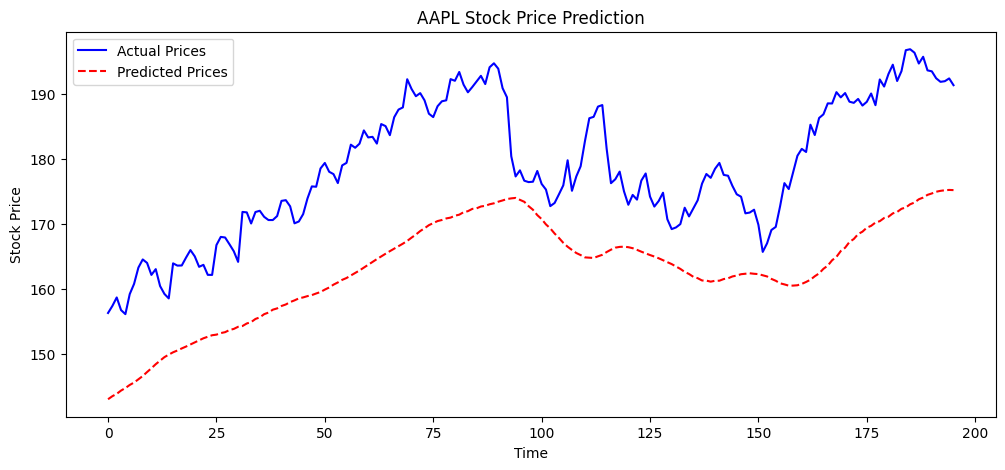

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout

# تحميل بيانات سهم آخر (استبدل بالرمز الذي تريده)
ticker = "AAPL"  # مثلاً: أبل
data = yf.download(ticker, start="2020-01-01", end="2024-01-01", interval="1d")

# استخراج أسعار الإغلاق وتطبيعها
closing_prices = data['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
closing_prices_scaled = scaler.fit_transform(closing_prices)

def create_sequences(data, time_steps=30):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)

time_steps = 30
X, y = create_sequences(closing_prices_scaled, time_steps)
X = X.reshape(X.shape[0], X.shape[1], 1)

# تقسيم البيانات
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# بناء النموذج
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(time_steps, 1)),
    MaxPooling1D(pool_size=2),
    LSTM(50, return_sequences=True),
    LSTM(50),
    Dense(50, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='linear')
])

# تجميع وتدريب النموذج
model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# تقييم النموذج
loss = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)

y_test_original = scaler.inverse_transform(y_test)
y_pred_original = scaler.inverse_transform(y_pred)

mse = mean_squared_error(y_test_original, y_pred_original)
print(f"📉 Mean Squared Error (MSE): {mse:.4f}")

# رسم القيم الفعلية مقابل القيم المتوقعة
plt.figure(figsize=(12, 5))
plt.plot(y_test_original, label="Actual Prices", color="blue")
plt.plot(y_pred_original, label="Predicted Prices", color="red", linestyle="dashed")
plt.title(f"{ticker} Stock Price Prediction")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()
